In [1]:
# Erasmus+ ICCT project (2018-1-SI01-KA203-047081)

# Toggle cell visibility

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import scipy.signal as signal
from ipywidgets import widgets, interact
import control as cn

## Luogo delle radici

Il luogo delle radici è un grafico che rappresenta la posizione dei poli e degli zeri del sistema ad anello chiuso in relazione a un determinato parametro (tipicamente il guadagno). Si può dimostrare che le curve iniziano nei poli ad anello aperto e finiscono negli zeri ad anello aperto (o all'infinito). La posizione dei poli del sistema a ciclo chiuso non solo fornisce un'indicazione della stabilità del sistema, tramite questa è anche possibile ricavare altre proprietà di risposta del sistema in anello chiuso come l'overshoot, il tempo di salita e il tempo di assestamento.

---

### Come usare questo notebook?
1. Seleziona *P0*, *P1*, *I0* o *I1* per alternare tra i seguenti sistemi: proporzionale, primo ordine, integrale o integrale con un polo stabile. La funzione di trasferimento di P0 è $k_p$ (in questo esempio $k_p=2$), di PI $\frac{k_p}{\tau s+1}$ (in questo esempio $k_p=1$ e $\tau=2$), di IO $\frac{k_i}{s}$ (in questo esempio $k_i=\frac{1}{10}$) e di I1 $\frac{k_i}{s(\tau s +1)}$ (in questo esempio $k_i=1$ e $\tau=10$).
2. Seleziona uno tra *P*, *PI*, *PD* o *PID* per scegliere tra un controllore proporzionale, proporzionale-integrale, proporzionale-derivativo o proporzionale-integrale-derivativo.
3. Spostare gli sliders per modificare i valori dei coefficienti di regolazione PID: proporzionale ($K_p$), integrale ($T_i$) e derivativo ($T_d$).
4. Sposta il cursore $t_{max}$ per modificare il valore massimo del tempo sull'asse x.

<IPython.core.display.Javascript object>


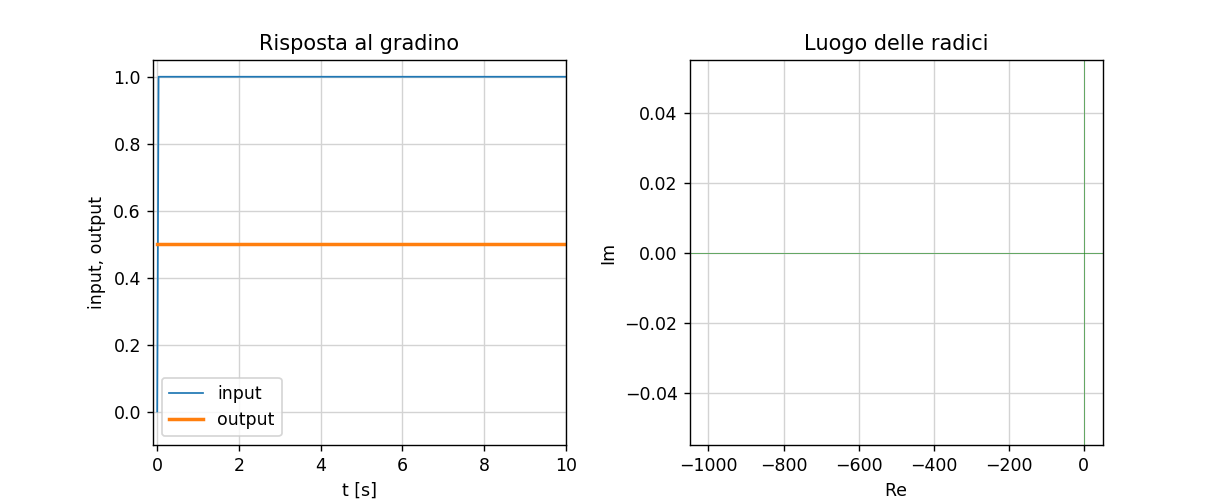

ToggleButtons(description='Seleziona il sistema:', options=('P0', 'P1', 'I0', 'I1'), style=ToggleButtonsStyle(…

ToggleButtons(description='Seleziona il tipo di controller:', options=('P', 'PI', 'PD', 'PID'), style=ToggleBu…

interactive(children=(FloatLogSlider(value=0.5, description='\\(K_p\\)', max=2.1, min=-3.0, readout_format='.3…

In [3]:
A = 10
a=0.1
s, P, I, D = sym.symbols('s, P, I, D')

obj = 1/(A*s)
PID = P + P/(I*s) + P*D*s#/(a*D*s+1)
system = obj*PID/(1+obj*PID)
num = [sym.fraction(system.factor())[0].expand().coeff(s, i) for i in reversed(range(1+sym.degree(sym.fraction(system.factor())[0], gen=s)))]
den = [sym.fraction(system.factor())[1].expand().coeff(s, i) for i in reversed(range(1+sym.degree(sym.fraction(system.factor())[1], gen=s)))]
system_func_open = obj*PID
num_open = [sym.fraction(system_func_open.factor())[0].expand().coeff(s, i) for i in reversed(range(1+sym.degree(sym.fraction(system_func_open.factor())[0], gen=s)))]
den_open = [sym.fraction(system_func_open.factor())[1].expand().coeff(s, i) for i in reversed(range(1+sym.degree(sym.fraction(system_func_open.factor())[1], gen=s)))]
    
# make figure
fig = plt.figure(figsize=(9.8, 4),num='Luogo delle radici')
plt.subplots_adjust(wspace=0.3)

# add axes
ax = fig.add_subplot(121)
ax.grid(which='both', axis='both', color='lightgray')
ax.set_title('Risposta al gradino')
ax.set_xlabel('t [s]')
ax.set_ylabel('input, output')

rlocus = fig.add_subplot(122)


# plot step function and responses (initalisation)
input_plot, = ax.plot([],[],'C0', lw=1, label='input')
response_plot, = ax.plot([],[], 'C1', lw=2, label='output')
ax.legend()

rlocus_plot, = rlocus.plot([], [], 'r')

plt.show()

system_open = None
system_close = None
def update_plot(KP, TI, TD, Time_span):
    global num, den, num_open, den_open
    global system_open, system_close
    num_temp = [float(i.subs(P,KP).subs(I,TI).subs(D,TD)) for i in num]
    den_temp = [float(i.subs(P,KP).subs(I,TI).subs(D,TD)) for i in den]
    system = signal.TransferFunction(num_temp, den_temp)
    system_close = system
    num_temp_open = [float(i.subs(P,KP).subs(I,TI).subs(D,TD)) for i in num_open]
    den_temp_open = [float(i.subs(P,KP).subs(I,TI).subs(D,TD)) for i in den_open]
    system_open = signal.TransferFunction(num_temp_open, den_temp_open)
    
    rlocus.clear()
#     r, k, xlim, ylim = cn.root_locus_modified(system_open, Plot=False)
    r, k = cn.root_locus(system_open, Plot=False)
    #rlocus.scatter(r)
    #plot closed loop poles and zeros
    poles = np.roots(system.den)
    rlocus.plot(np.real(poles), np.imag(poles), 'kx')
    zeros = np.roots(system.num)
    if zeros.size > 0:
        rlocus.plot(np.real(zeros), np.imag(zeros), 'ko', alpha=0.5)
    # plot open loop poles and zeros
    poles = np.roots(system_open.den)
    rlocus.plot(np.real(poles), np.imag(poles), 'x', alpha=0.5)
    zeros = np.roots(system_open.num)
    if zeros.size > 0:
        rlocus.plot(np.real(zeros), np.imag(zeros), 'o')
    #plot root locus
    for index, col in enumerate(r.T):
        rlocus.plot(np.real(col), np.imag(col), 'b', alpha=0.5)
    
    rlocus.set_title('Luogo delle radici')
    rlocus.set_xlabel('Re')
    rlocus.set_ylabel('Im')
    rlocus.grid(which='both', axis='both', color='lightgray')
    
    rlocus.axhline(linewidth=.3, color='g')
    rlocus.axvline(linewidth=.3, color='g')
#     rlocus.set_ylim(ylim)
#     rlocus.set_xlim(xlim)
    
    time = np.linspace(0, Time_span, 300)
    u = np.ones_like(time)
    u[0] = 0
    time, response = signal.step(system, T=time)
        
    response_plot.set_data(time, response)
    input_plot.set_data(time, u)
    
    ax.set_ylim([min([np.min(u), min(response),-.1]),min(100,max([max(response)*1.05, 1, 1.05*np.max(u)]))])
    ax.set_xlim([-0.1,max(time)])

    plt.show()

controller_ = PID
object_ = obj

def calc_tf():
    global num, den, controller_, object_, num_open, den_open
    system_func = object_*controller_/(1+object_*controller_)
    
    num = [sym.fraction(system_func.factor())[0].expand().coeff(s, i) for i in reversed(range(1+sym.degree(sym.fraction(system_func.factor())[0], gen=s)))]
    den = [sym.fraction(system_func.factor())[1].expand().coeff(s, i) for i in reversed(range(1+sym.degree(sym.fraction(system_func.factor())[1], gen=s)))]
    
    system_func_open = object_*controller_
    num_open = [sym.fraction(system_func_open.factor())[0].expand().coeff(s, i) for i in reversed(range(1+sym.degree(sym.fraction(system_func_open.factor())[0], gen=s)))]
    den_open = [sym.fraction(system_func_open.factor())[1].expand().coeff(s, i) for i in reversed(range(1+sym.degree(sym.fraction(system_func_open.factor())[1], gen=s)))]
    
    update_plot(Kp_widget.value, Ti_widget.value, Td_widget.value, time_span_widget.value)

def transfer_func(controller_type):
    global controller_
    proportional = P
    integral = P/(I*s)
    differential = P*D*s/(a*D*s+1)
    if controller_type =='P':
        controller_func = proportional
        Kp_widget.disabled=False
        Ti_widget.disabled=True
        Td_widget.disabled=True
    elif controller_type =='PI':
        controller_func = proportional+integral
        Kp_widget.disabled=False
        Ti_widget.disabled=False
        Td_widget.disabled=True
    elif controller_type == 'PD':
        controller_func = proportional+differential
        Kp_widget.disabled=False
        Ti_widget.disabled=True
        Td_widget.disabled=False
    else:
        controller_func = proportional+integral+differential
        Kp_widget.disabled=False
        Ti_widget.disabled=False
        Td_widget.disabled=False
    
    controller_ = controller_func
    calc_tf()
    
def transfer_func_obj(object_type):
    global object_
    if object_type == 'P0':
        object_ = 2
    elif object_type == 'P1':
        object_ = 1/(2*s+1) 
    elif object_type == 'I0':
        object_ = 1/(10*s)
    elif object_type == 'I1':
        object_ = 1/(s*(10*s+1))
    calc_tf()

style = {'description_width': 'initial'}

def buttons_controller_clicked(event):
    controller = buttons_controller.options[buttons_controller.index]
    transfer_func(controller)
buttons_controller = widgets.ToggleButtons(
    options=['P', 'PI', 'PD', 'PID'],
    description='Seleziona il tipo di controller:',
    disabled=False,
    style=style)
buttons_controller.observe(buttons_controller_clicked)

def buttons_object_clicked(event):
    object_ = buttons_object.options[buttons_object.index]
    transfer_func_obj(object_)
buttons_object = widgets.ToggleButtons(
    options=['P0', 'P1', 'I0', 'I1'],
    description='Seleziona il sistema:',
    disabled=False,
    style=style)
buttons_object.observe(buttons_object_clicked)

    
Kp_widget = widgets.FloatLogSlider(value=.5,min=-3,max=2.1,step=.001,description=r'\(K_p\)',
    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.3f')
Ti_widget = widgets.FloatLogSlider(value=1.,min=-3,max=1.8,step=.001,description=r'\(T_{i} \)',
    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.3f')
Td_widget = widgets.FloatLogSlider(value=1.,min=-3,max=1.8,step=.001,description=r'\(T_{d} \)',
    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.3f')

time_span_widget = widgets.FloatSlider(value=10.,min=.5,max=50.,step=0.1,description=r'\(t_{max} \)',
    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.1f')

transfer_func(buttons_controller.options[buttons_controller.index])
transfer_func_obj(buttons_object.options[buttons_object.index])

display(buttons_object)
display(buttons_controller)

interact(update_plot, KP=Kp_widget, TI=Ti_widget, TD=Td_widget, Time_span=time_span_widget);